In [38]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

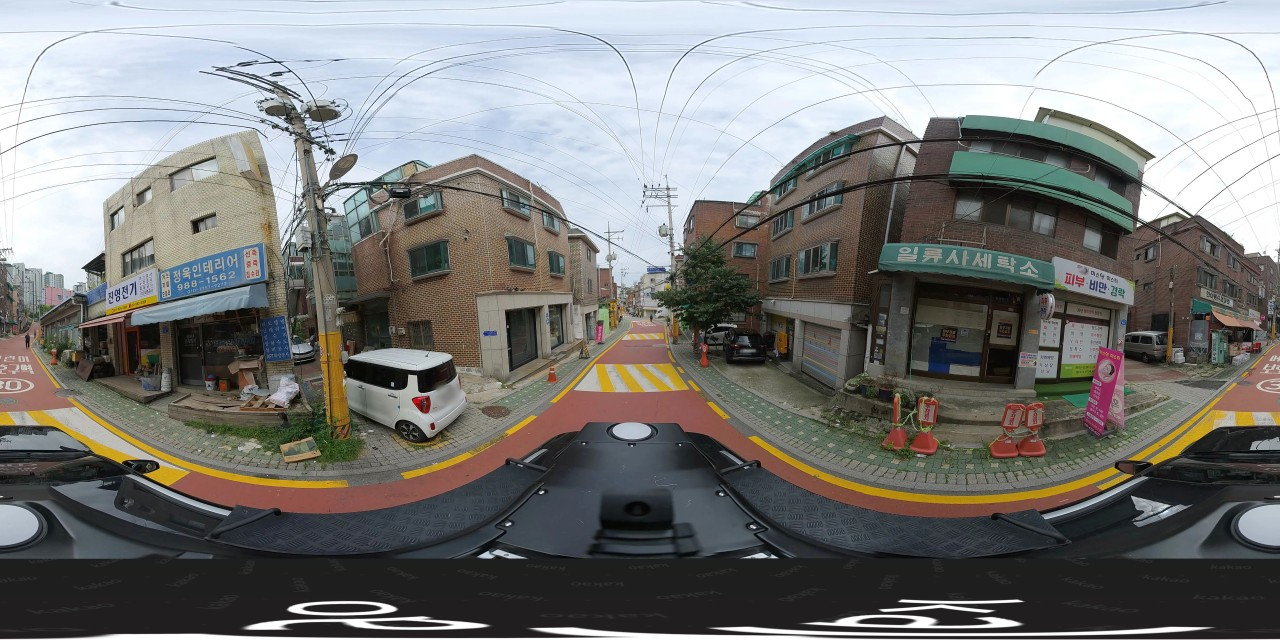

In [39]:
from PIL import Image

image = Image.open("img/pano_3.png")
image

In [40]:
# 세그먼트할 텍스트 카테고리 정의
prompts = ["sidewalk", "road", "building", "tree"]

In [41]:
import torch

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

[Text(0, -15, 'sidewalk'),
 Text(0, -15, 'road'),
 Text(0, -15, 'building'),
 Text(0, -15, 'tree')]

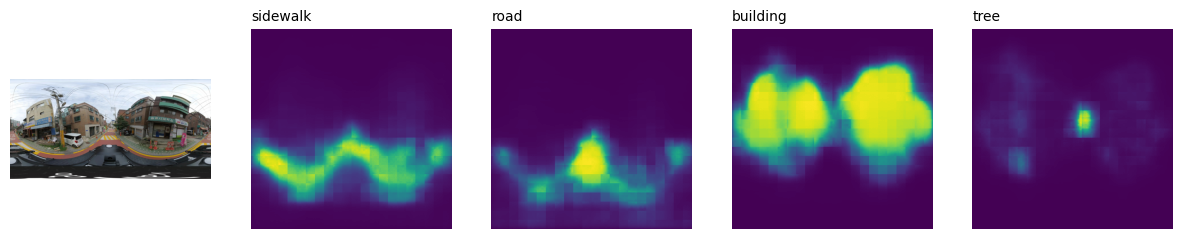

In [42]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))]
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)]

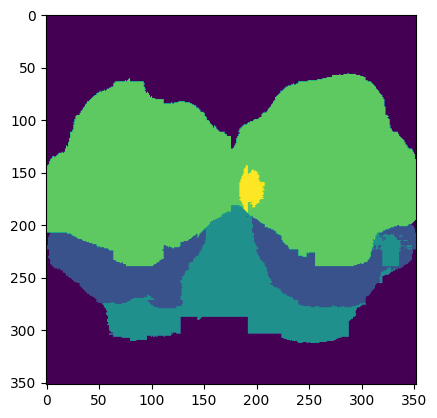

In [43]:
threshold = 0.2

flat_preds = torch.sigmoid(preds.squeeze()).reshape((preds.shape[0], -1))

# Initialize a dummy "unlabeled" mask with the threshold
flat_preds_with_treshold = torch.full((preds.shape[0] + 1, flat_preds.shape[-1]), threshold)
flat_preds_with_treshold[1:preds.shape[0]+1,:] = flat_preds

# Get the top mask index for each pixel
inds = torch.topk(flat_preds_with_treshold, 1, dim=0).indices.reshape((preds.shape[-2], preds.shape[-1]))

plt.imshow(inds)

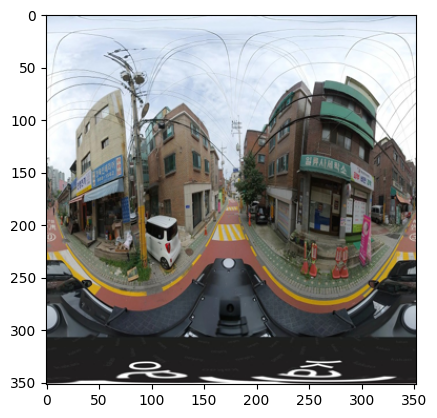

In [44]:
# 원본 이미지도 reshape 하기
image = image.resize((preds.shape[-1], preds.shape[-2]))
plt.imshow(image)

/var/folders/r1/m1t1_dyn223dl13gsgrsw8240000gn/T/ipykernel_51057/3187377371.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('jet', len(prompts))


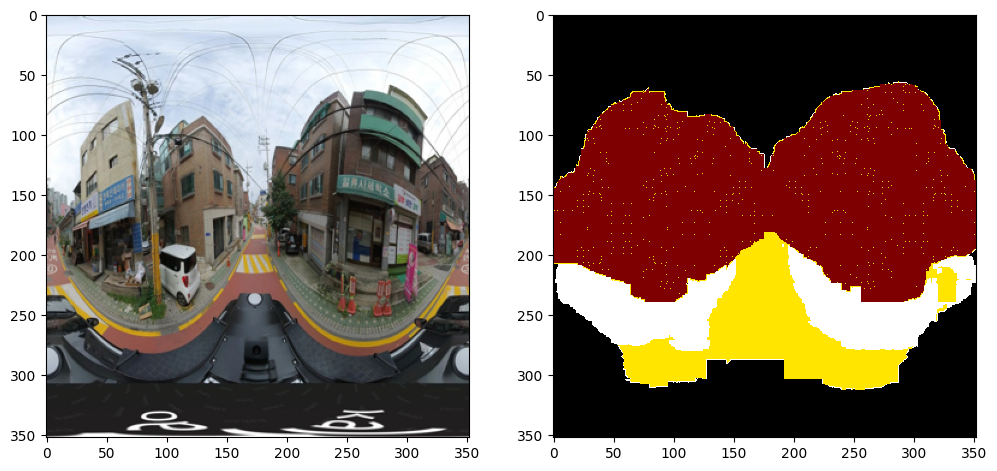

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Create a custom color map
colors = cm.get_cmap('jet', len(prompts))
newcolors = colors(np.linspace(0, 1, len(prompts)))
newcolors[0,:] = np.array([0,0,0,1])
newcolors[1,:] = np.array([1,1,1,1])
newcmp = ListedColormap(newcolors)

# Plot the image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[1].imshow(inds, cmap=newcmp)